In [1]:
%cd /Users/jye98/Desktop/dataset/imagedata

/Users/jye98/Desktop/dataset/imagedata


In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import os

In [3]:
image_datas = glob.glob('./**/*.jpg')
class_name = ["StyleGAN3", "RealImage"]
dic = {"StyleGAN3":0, "RealImage":1}

In [4]:
x = []
y = []
for imagename in image_datas:
    image = Image.open(imagename)
    image = image.resize((384,384))
    image = np.array(image)
    x.append(image)
    label = imagename.split(('/'),maxsplit=2)[1]
    label = dic[label]
    y.append(label)

In [5]:
x = np.array(x)
y = np.array(y)

In [6]:
train_images, test_images, train_labels, test_labels = train_test_split(x, y, test_size=0.3, shuffle= True, random_state=777)
train_labels = train_labels[..., tf.newaxis]
test_labels = test_labels[..., tf.newaxis]

test_images.shape, test_labels.shape, train_images.shape, train_labels.shape

((498, 384, 384, 3), (498, 1), (1160, 384, 384, 3), (1160, 1))

In [7]:
#training set의 각 class 별 image 수 확인
unique, counts = np.unique(np.reshape(train_labels, (1160,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 576, 1: 584}

In [8]:
#test set의 각 class 별 image 수 확인
unique, counts = np.unique(np.reshape(test_labels, (498,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 253, 1: 245}

In [9]:
N_TRAIN = train_images.shape[0]
N_TEST = test_images.shape[0] 

In [10]:
train_images = train_images.astype(np.int32) / 255.
test_images = test_images.astype(np.int32) / 255.
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

In [11]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(1160, 384, 384, 3) (1160, 2)
(498, 384, 384, 3) (498, 2)


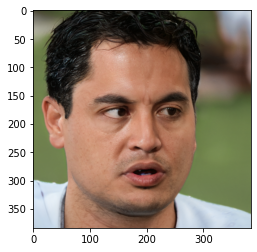

In [12]:
plt.imshow(test_images[0])

In [13]:
N_EPOCHS = 20
N_BATCH = 4
N_CLASS = 5

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(buffer_size=1243).batch(N_BATCH).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(N_BATCH)

2022-05-26 18:33:58.579896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-26 18:33:58.580056: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [15]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math
input_tensor = Input(shape=(384, 384, 3), dtype='float32', name='input')

 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
    
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(2, activation='softmax')(x)
 
resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 390, 390, 3)  0          ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 192, 192, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [16]:
steps_per_epoch = math.ceil(N_TRAIN/N_BATCH)
validation_steps = math.ceil(N_TEST/N_BATCH)
print(steps_per_epoch, validation_steps)

290 125


In [19]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

import matplotlib.pyplot as plt
import math

In [20]:
loss = binary_crossentropy
resnet50.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])
hist = resnet50.fit(train_dataset, epochs=N_EPOCHS,steps_per_epoch=steps_per_epoch,validation_data=test_dataset,validation_steps=validation_steps,verbose=1)

Epoch 1/20


2022-05-26 18:36:44.660992: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-26 18:36:44.661400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


290/290 [==============================] - ETA: 0s - loss: 0.8280 - accuracy: 0.5224

2022-05-26 18:38:03.628228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


290/290 [==============================] - 90s 290ms/step - loss: 0.8280 - accuracy: 0.5224 - val_loss: 0.8052 - val_accuracy: 0.5141
Epoch 2/20
290/290 [==============================] - 83s 287ms/step - loss: 0.7422 - accuracy: 0.4974 - val_loss: 3.1198 - val_accuracy: 0.4920
Epoch 3/20
290/290 [==============================] - 84s 289ms/step - loss: 0.7279 - accuracy: 0.4940 - val_loss: 0.7950 - val_accuracy: 0.4819
Epoch 4/20
290/290 [==============================] - 83s 287ms/step - loss: 0.7243 - accuracy: 0.4940 - val_loss: 0.7148 - val_accuracy: 0.4920
Epoch 5/20
290/290 [==============================] - 83s 286ms/step - loss: 0.7098 - accuracy: 0.5233 - val_loss: 1.3718 - val_accuracy: 0.5080
Epoch 6/20
290/290 [==============================] - 84s 288ms/step - loss: 0.7116 - accuracy: 0.5069 - val_loss: 1.2467 - val_accuracy: 0.5040
Epoch 7/20
290/290 [==============================] - 83s 286ms/step - loss: 0.7121 - accuracy: 0.5121 - val_loss: 0.6969 - val_accuracy: 0.5

In [21]:
resnet50.evaluate(test_dataset)

125/125 [==============================] - 9s 67ms/step - loss: 0.6853 - accuracy: 0.5763


[0.6853365302085876, 0.5763052701950073]

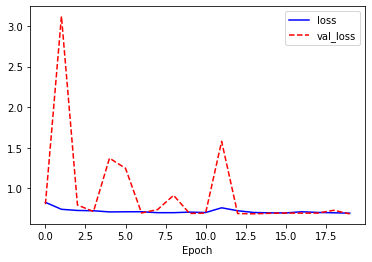

In [22]:
plt.plot(hist.history['loss'], '-b', label ='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

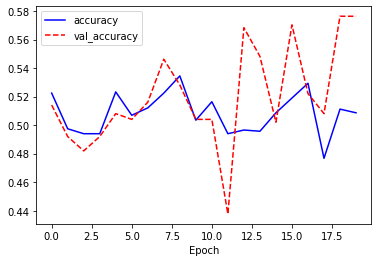

In [23]:
plt.plot(hist.history['accuracy'], 'b-', label='accuracy')
plt.plot(hist.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()